In [27]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report  

# Explications des données

On a installé sur le site du [DEFT 2009](https://deft.lisn.upsaclay.fr/) les données pour réaliser la tâche 3 qui est la suivante :
- entraîner un modèle qui détermine automatiquement le parti politique d’appartenance de chaque intervenant dans le corpus parlementaire.

Il y a en tout 5 classes qui correspondent aux différents partis politiques : 
- Verts-ALE
- GUENGL
- PSE
- ELDR
- PPE-DE

In [43]:
# Fréquence des classes dans df_train
print("Distribution des classes dans df_train :")
print(df_train["valeur"].value_counts())

# Fréquence des classes dans df_test
print("Distribution des classes dans df_test :")
print(df_test["valeur"].value_counts())

Distribution des classes dans df_train :
valeur
PPE-DE       4635
PSE          3650
GUE-NGL      1823
Verts-ALE    1609
ELDR         1351
Name: count, dtype: int64
Distribution des classes dans df_test :
valeur
PPE-DE       3047
PSE          2489
GUE-NGL      1196
Verts-ALE    1072
ELDR          908
Name: count, dtype: int64


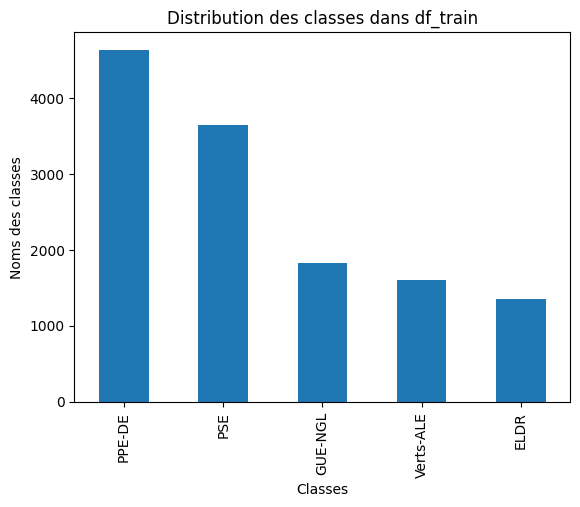

In [41]:
df_train["valeur"].value_counts().plot(kind="bar", title="Distribution des classes dans df_train")
plt.xlabel("Classes")
plt.ylabel("Noms des classes")
plt.show()

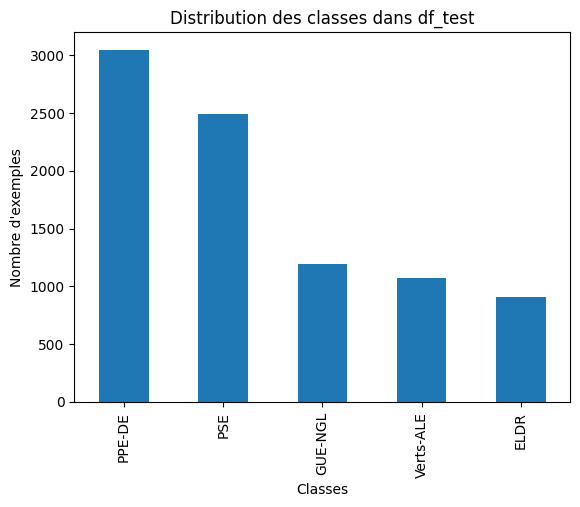

In [42]:
df_test["valeur"].value_counts().plot(kind="bar", title="Distribution des classes dans df_test")
plt.xlabel("Classes")
plt.ylabel("Nombre d'exemples")
plt.show()

# Extraction des données

In [29]:
def get_xml_content(file):

    with open(file, "r") as f:
        soup = BeautifulSoup(f, "xml")

    return soup

In [30]:
def extract_train_info(doc):

    doc_dico = {}

    # Extraire l'id
    doc_id = doc.get("id")
    doc_dico["id"] = doc_id

   # Extraire l'évaluation
    evaluation = doc.find("EVALUATION")
    evaluation_parti = evaluation.find("EVAL_PARTI")
    doc_dico["nombre"] = evaluation_parti.get("nombre")

    parti = evaluation_parti.find("PARTI")
    doc_dico["valeur"] = parti.get("valeur")
    doc_dico["confiance"] = parti.get("confiance")

    # Extraire le texte
    texte = doc.find("p")
    doc_dico["texte"] = texte.text

    return doc_dico

In [31]:
def get_test_labels(file):

    with open(file, "r") as f:
        lines = f.readlines()

    lines = [line.split("\t") for line in lines]
    labels = {line[0]: line[1].strip() for line in lines}

    return labels

J'ai remarqué plus tard que deux textes de l'ensemble de test n'avaient pas de labels

In [32]:
labels = get_test_labels("data/ref/deft09_parlement_ref_fr.txt")
for key, value in labels.items():
    if value == "":
        print(key)

1175
4574


Je fais donc en sorte lorsque j'obtiens la df que si la valeur est égale à "" alors je ne prends pas le texte en compte.

In [33]:
def extract_test_info(doc):

    doc_dico = {}

    doc_id = doc.get("id")
    doc_dico["id"] = doc_id

    texte = doc.find("p")
    doc_dico["texte"] = texte.text

    return doc_dico

In [34]:
def get_train_and_test_df(train_file, test_file, ref_file):

    soup_train = get_xml_content(train_file)
    soup_test = get_xml_content(test_file)

    test_labels = get_test_labels(ref_file)

    all_docs = []
    for doc in soup_train.find_all("doc"):
        doc_dico = extract_train_info(doc)
        all_docs.append(doc_dico)
    
    df_train = pd.DataFrame(all_docs)

    all_docs = []
    for doc in soup_test.find_all("doc"):
        doc_dico = extract_test_info(doc)
        if test_labels[doc_dico["id"]] == "": # pour les deux textes sans label dans le fichier de référence
            continue
        doc_dico["valeur"] = test_labels[doc_dico["id"]]
        all_docs.append(doc_dico)

    df_test = pd.DataFrame(all_docs)
    
    return df_train, df_test

In [35]:
df_train, df_test = get_train_and_test_df("data/train/deft09_parlement_appr_fr.xml", "data/test/deft09_parlement_test_fr.xml", "data/ref/deft09_parlement_ref_fr.txt")

KeyboardInterrupt: 

In [9]:
df_train

,id,nombre,valeur,confiance,texte
0,2_fr:1,1,Verts-ALE,1.00,"Monsieur le Président, j'ai toujours fait preu..."
1,2_fr:2,1,PPE-DE,1.00,"Madame la Présidente, chers collègues, à l'app..."
2,2_fr:3,1,Verts-ALE,1.00,"Je voudrais savoir si l'Union européenne, à la..."
3,2_fr:4,1,PSE,1.00,"Madame la Présidente, au nom des de la commis..."
4,2_fr:5,1,PSE,1.00,"Monsieur le Président, chers collègues, Monsie..."
...,...,...,...,...,...
19365,2_fr:19366,1,PSE,1.00,"Monsieur le Président, je voudrais tout d’abor..."
19366,2_fr:19367,1,PPE-DE,1.00,"Monsieur le Président, Monsieur le Commissaire..."
19367,2_fr:19368,1,PPE-DE,1.00,"Monsieur le Président, je tiens à déclarer, au..."
19368,2_fr:19369,1,PPE-DE,1.00,"Monsieur le Président, l’aide à l’Albanie et à..."


In [ ]:
df_test

,id,texte,valeur
0,1,"Monsieur le Président, l'accès à des médias li...",ELDR
1,2,"Monsieur le Président, j'ai un point de vue di...",GUE-NGL
2,3,"Monsieur le Président, Monsieur le Commissaire...",PPE-DE
3,4,Nous ne pouvons soutenir cette tentative d’éri...,GUE-NGL
4,5,"Monsieur le Président, ce court débat se dérou...",PPE-DE
...,...,...,...
12910,12913,"Monsieur le Président, Madame la Commissaire, ...",PPE-DE
12911,12914,"Monsieur le Président, Monsieur le Commissaire...",PPE-DE
12912,12915,"Madame la Présidente, permettez-moi de m'adres...",ELDR
12913,12916,Grâce à la proposition de directive dont trait...,GUE-NGL


# Présentation des données

## Doublons

### Combien de doublons ?

In [11]:
train_texts = df_train["texte"].to_list()
test_texts = df_test["texte"].to_list()

In [12]:
def check_copy(train_texts, test_texts):

    num_copy = 0

    for text in train_texts:
        if text in test_texts:
            num_copy += 1

    return num_copy

In [ ]:
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Il y a 7813 textes en commun entre les données d'entraînement et de test.


### On veut atteindre une distribution

Répartition des sets = 60 et 40

In [14]:
def get_distribution(df_train, df_test):

    total_texts = len(df_train) + len(df_test)
    percentage_train = len(df_train) / total_texts * 100
    percentage_test = len(df_test) / total_texts * 100

    return percentage_train, percentage_test

In [ ]:
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")

Pourcentage de textes d'entraînement : 60.00%
Pourcentage de textes de test : 40.00%


On veut enlever les doublons tout en essayant de conserver cette distribution.

In [16]:
def balance_distribution(df_train, df_test):

    train_texts = df_train["texte"].to_list()
    test_texts = df_test["texte"].to_list()

    for text in train_texts:
        if text in test_texts:
            percentage_train, percentage_test = get_distribution(df_train, df_test)
            difference_train = abs(percentage_train - 60)
            difference_test = abs(percentage_test - 40)

            if difference_train > difference_test:
                df_test = df_test[df_test["texte"] != text]
            else:
                df_train = df_train[df_train["texte"] != text]

    return df_train, df_test

In [ ]:
df_train, df_test = balance_distribution(df_train, df_test)
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")

Pourcentage de textes d'entraînement : 53.40%
Pourcentage de textes de test : 46.60%


In [ ]:
train_texts = df_train["texte"].to_list()
test_texts = df_test["texte"].to_list()
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Il y a 0 textes en commun entre les données d'entraînement et de test.


### Retirer jusqu'à 60

Nous n'avons plus de doublons mais nous restons quelque peu éloignés de la distribution 60/40. On va donc retirer des textes de l'ensemble de test pour arriver à la distribution souhaitée.

In [19]:
def reach_desired_distribution(df_train, df_test):

    while True:
        percentage_train, percentage_test = get_distribution(df_train, df_test)

        if percentage_train >= 60:
            break
        else:
            df_test = df_test.drop(df_test.index[0])

    
    return df_train, df_test

In [ ]:
df_train, df_test = reach_desired_distribution(df_train, df_test)
percentage_train, percentage_test = get_distribution(df_train, df_test)
print(f"Pourcentage de textes d'entraînement : {percentage_train:.2f}%")
print(f"Pourcentage de textes de test : {percentage_test:.2f}%")
num_copy = check_copy(train_texts, test_texts)
print(f"Il y a {num_copy} textes en commun entre les données d'entraînement et de test.")

Pourcentage de textes d'entraînement : 60.00%
Pourcentage de textes de test : 40.00%
Il y a 0 textes en commun entre les données d'entraînement et de test.


In [21]:
df_train.to_csv("data/train.csv", index=False)
df_test.to_csv("data/test.csv", index=False)

## Visualisation des données

Est-ce que les classes sont représentées de manière égale entre les deux ensembles ?

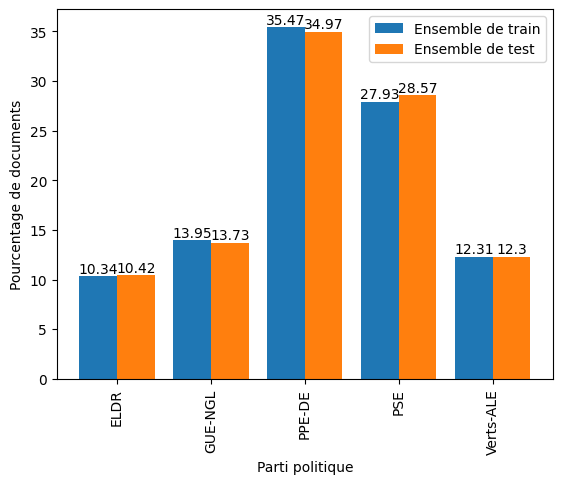

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compare_class_distribution(df_train, df_test):

    total_train = len(df_train)
    total_test = len(df_test)

    train_distribution = {source: count / total_train * 100 for source, count in df_train.groupby("valeur").size().to_dict().items()}
    test_distribution = {source: count / total_test * 100 for source, count in df_test.groupby("valeur").size().to_dict().items()}

    x = np.arange(len(train_distribution))
    width = 0.4
    train_bars = plt.bar(x - 0.2, train_distribution.values(), width, label="Ensemble de train")
    test_bars = plt.bar(x + 0.2, test_distribution.values(), width, label="Ensemble de test")

    for bar in train_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha='center', va='bottom')

    for bar in test_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha='center', va='bottom')

    plt.xticks(x, train_distribution.keys(), rotation=90)
    plt.xlabel("Parti politique")
    plt.ylabel("Pourcentage de documents")
    plt.legend()
    plt.show()

compare_class_distribution(df_train, df_test)


Les répartitions sont assez égalitaires ! 


||   ELDR    | GUE/NGL | PPE-DE     | PSE | Verts/ALE
|:---| :---        |    :----   |          :--- | :--- | :--- |
|Nombre de documents| 3 346 | 4 482   |  11 429 | 9 066 | 3 961 |
|Pourcentage de documents|10.33%|13.84%|35.29%|27.99%|12.23%|

On a donc un corpus sans doublons mais avec une répartition et une distribution des classes et des documents fidèle au corpus originel !

# Pé-traitement des données

## - Normalisation

In [45]:
import spacy
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [47]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [48]:
nlp = spacy.load("en_core_web_sm")

In [87]:
def lemmatisation(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [88]:
def i_love_lowercase(text):

    return text.lower()

In [89]:
def remove_stop_words(text):
    
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]

    return " ".join(filtered_text)

In [90]:
def remove_punctuation(text):

    text = re.sub(r"[^\w\s]", "", text)
    
    return text

In [91]:
def get_beautiful_clean_text(text):

    text = i_love_lowercase(text)
    text = remove_punctuation(text)
    text = remove_stop_words(text)
    text = lemmatisation(text)

    return text

df_train["texte_nettoyé"] = df_train["texte"].map(get_beautiful_clean_text)
df_test["texte_nettoyé"] = df_test["texte"].map(get_beautiful_clean_text)

In [92]:
df_train.to_csv("data/train.csv", index=False)
df_test.to_csv("data/test.csv", index=False)


In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [4]:
df_train.head()

,id,nombre,valeur,confiance,texte,texte_nettoyé
0,2_fr:2,1,PPE-DE,1.0,"Madame la Présidente, chers collègues, à l'app...",madame la présidente cher collègue à lapproche...
1,2_fr:5,1,PSE,1.0,"Monsieur le Président, chers collègues, Monsie...",monsieur le président cher collègue monsieur l...
2,2_fr:6,1,Verts-ALE,1.0,"C'est une motion de procédure, la question 67 ...",cest une motion de procédure la question 67 de...
3,2_fr:7,1,PPE-DE,1.0,"Monsieur le Président, nous sommes favorables ...",monsieur le président nous somme favorable à c...
4,2_fr:9,1,PSE,1.0,"Madame la Présidente, je ne vois rien de discr...",madame la présidente je ne vois rien de discri...


## Vectorisation

Dans l'article, on voit que les paramètres de la vectorisation jouent un rôle assez important.
Nous allons donc essayer de tester cela avec le tfidf et le count vectorizer sur le KNN, l'algorithme utilisé dans l'article. 
Nous allons vectorisser de manière différentes nos données et stocker le tout dans une df assez grande. NOus allons ensuite tester le tout sur le KNN pour voir comment cela impacte nos données et jusqu'à ou on peut aller !

## Organisation

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

In [6]:
vectorizers = {
    "TfidfVectorizer": {
        "model": TfidfVectorizer(),
        "hyperparameters": {
            "max_df": [0.5, 0.9, 1], # ça c'est pour ignorer les mots qui appraîssent dans 0.5 ou 0.9 des documents #defaut = 1
            "max_features": [1000, 5000, 10000, 15000], # ça c'est pour limiter le nombre de mots à 1000 ou 2000 #defaut = None
            "ngram_range": [(1, 1), (1, 2)], # ça c'est pour prendre en compte les unigrammes ou les bigrammes #defaut = (1, 1)
        }
    },
    "CountVectorizer": {
        "model": CountVectorizer(),
        "hyperparameters": {
            "max_df": [0.8, 0.9],
            "max_features": [1000, 5000, 10000, 15000],
            "ngram_range": [(1, 1), (1, 2)],
        }
    }
    
}

In [7]:
from itertools import product

def hyperparameter_vectorizer(vectorizers):

    param_grid = vectorizers["hyperparameters"]
    list_vectorizers = []


    if len(param_grid) == 1:
        param_name, param_values = list(param_grid.items())[0]
        for i, value in enumerate(param_values, start=1):
            params = {param_name: value}
            vectorizer = vectorizers["model"].__class__(**params) 
            list_vectorizers.append(vectorizer)

    else:
        param_grid_combinations = list(product(*param_grid.values()))
        for i, combination in enumerate(param_grid_combinations, start=1):
            params = {param_name: value for param_name, value in zip(param_grid.keys(), combination)}
            vectorizer = vectorizers["model"].__class__(**params) 
            list_vectorizers.append(vectorizer)

    return list_vectorizers

In [8]:
list_vectorizers = hyperparameter_vectorizer(vectorizers["TfidfVectorizer"])
list_vectorizers

[TfidfVectorizer(max_df=0.5, max_features=1000),
 TfidfVectorizer(max_df=0.5, max_features=1000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.5, max_features=5000),
 TfidfVectorizer(max_df=0.5, max_features=5000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.5, max_features=10000),
 TfidfVectorizer(max_df=0.5, max_features=10000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.5, max_features=15000),
 TfidfVectorizer(max_df=0.5, max_features=15000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=1000),
 TfidfVectorizer(max_df=0.9, max_features=1000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=5000),
 TfidfVectorizer(max_df=0.9, max_features=5000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=10000),
 TfidfVectorizer(max_df=0.9, max_features=10000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=0.9, max_features=15000),
 TfidfVectorizer(max_df=0.9, max_features=15000, ngram_range=(1, 2)),
 TfidfVectorizer(max_df=1, max_features=1000),
 

## Vectorisation des données

In [9]:
def store_vectorisations(list_vectorizers, x_train, x_test):

    all_vectorisations = []

    for i, vectorizer in enumerate(list_vectorizers):
        x_train_vectorized = vectorizer.fit_transform(x_train)
        x_test_vectorized = vectorizer.transform(x_test)
        all_vectorisations.append({"vectorizer_id": vectorizer.__class__.__name__ + str(i),
                                   "vectorizer": vectorizer, 
                                   "x_train": x_train_vectorized, 
                                   "x_test": x_test_vectorized})
    
    df_vectorisations = pd.DataFrame(all_vectorisations)

    return df_vectorisations

In [10]:
df_vectorisations = store_vectorisations(list_vectorizers, df_train["texte_nettoyé"], df_test["texte_nettoyé"])

## Test avec KNN

In [11]:
def im_counting_on_you_knn(df_vectorisations, y_train, y_test):

    model = KNeighborsClassifier(n_neighbors=1)
    scores = []

    for i, row in df_vectorisations.iterrows():
        vectorizer = row["vectorizer"]
        x_train = row["x_train"]
        x_test = row["x_test"]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        scores.append({"vectorizer": vectorizer, "scores": report})
                      
    return scores


In [12]:
scores = im_counting_on_you_knn(df_vectorisations, df_train["valeur"], df_test["valeur"])

In [15]:
sorted_scores = sorted(scores, key=lambda x: x["scores"]["accuracy"], reverse=True)

In [16]:
for score in sorted_scores:
    print(f"Vectorizer: {score['vectorizer'].__class__.__name__}")
    for key, value in score["scores"].items():
        print(f"\t{key}: {value}")

Vectorizer: TfidfVectorizer
	ELDR: {'precision': 0.18181818181818182, 'recall': 0.006607929515418502, 'f1-score': 0.012752391073326248, 'support': 908.0}
	GUE-NGL: {'precision': 0.13793103448275862, 'recall': 0.0033444816053511705, 'f1-score': 0.006530612244897959, 'support': 1196.0}
	PPE-DE: {'precision': 0.3506981109937815, 'recall': 0.9809648834919593, 'f1-score': 0.5166810717372515, 'support': 3047.0}
	PSE: {'precision': 0.3382352941176471, 'recall': 0.009240658899156288, 'f1-score': 0.01798983183418068, 'support': 2489.0}
	Verts-ALE: {'precision': 0.0847457627118644, 'recall': 0.0046641791044776115, 'f1-score': 0.008841732979664015, 'support': 1072.0}
	accuracy: 0.3474517906336088
	macro avg: {'precision': 0.2186856768248467, 'recall': 0.20096442652327262, 'f1-score': 0.1125591279738641, 'support': 8712.0}
	weighted avg: {'precision': 0.2676020058788204, 'recall': 0.3474517906336088, 'f1-score': 0.18916116139949027, 'support': 8712.0}
Vectorizer: TfidfVectorizer
	ELDR: {'precision

Résultats médiocres et le model avec la meilleure accuracy a des fscores désastreuses. PLutôt utiliser ces dernières pour l'évaluation.

# Comparaison

In [17]:
import time
def time_function(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        return result, end - start
    return wrapper

In [18]:
class Model:

    # Contient tous les modèles entrainés ! 
    all_models = []

    def __init__(self, name: str, model=None, vectorisation=None, scores={}, running_time=None, performance=None):
        self.name = name
        self.model = model
        self.vectorisation = vectorisation
        self.scores = scores
        self.running_time = running_time
        self.performance = performance

        Model.all_models.append(self)
        # Pour chaque modèle entraîné, on garde son nom (algo + num), le modèle et ses 
        # hyperparamètres pour cet entraînement, les métriques obtenues, et son temps d'execution !

    # Pour vider la liste si nécessaire ! 
    @classmethod
    def reset(cls):
        cls.all_models = []

    # Entraîne le modèle
    @time_function
    def fit_model(self, x_train, y_train):
        self.model.fit(x_train, y_train)
    
    # Prédictions et scores
    @time_function
    def predict(self, x_test, y_test):
        y_pred = self.model.predict(x_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_dict =  {"accuracy": accuracy, **report}
        self.scores = accuracy_dict
        return y_pred

      # Lance les fonctions d'entraînement et de prédiction
    # Stock les temps d'execution
    def test_model(self, x_train, y_train, x_test, y_test):
        _, fit_execution_time = self.fit_model(x_train, y_train)
        y_pred, predict_execution_time = self.predict(x_test, y_test)
        self.running_time = fit_execution_time + predict_execution_time

In [19]:
Model.reset()

In [25]:
models_dict = {
    "LogisticRegression": {"model": LogisticRegression(), "hyperparameters": {"C": [0.5, 1.0]}},
    # "SGDClassifier": {"model": SGDClassifier(), "hyperparameters": {"alpha": [0.0001, 0.001, 0.01], "loss": ["hinge", "squared_hinge"]}},
    "LinearSVC": {"model": LinearSVC(), "hyperparameters": {"C": [0.5, 1.0], "dual":[True, False]}},
    # "SVC": {"model": SVC(), "hyperparameters": {"kernel": ["poly", "sigmoid"]}},
    "RidgeClassifier": {"model": RidgeClassifier(), "hyperparameters": { "alpha": [1.0, 1.5, 2]}},
    "LGBMClassifier": {"model": LGBMClassifier(), "hyperparameters": {"max_depth": [1000], "n_estimators": [1000]}},
    "RandomForestClassifier": {"model": RandomForestClassifier(), "hyperparameters": {"max_depth": [100]}}
 }

In [21]:
from itertools import product

def hyperparameters_training(model_name, model_dict, x_train, y_train, x_test, y_test):
    param_grid = model_dict["hyperparameters"]

    if len(param_grid) == 1:
        param_name, param_values = list(param_grid.items())[0]
        for i, value in enumerate(param_values, start=1):
            params = {param_name: value}
            model = model_dict["model"].__class__(**params)  
            model_obj = Model(name=f"{model_name}_{i}", model=model)
            model_obj.test_model(x_train, y_train, x_test, y_test)
    else:
        param_grid_combinations = list(product(*param_grid.values()))
        for i, combination in enumerate(param_grid_combinations, start=1):
            params = {param_name: value for param_name, value in zip(param_grid.keys(), combination)}
            model = model_dict["model"].__class__(**params) 
            model_obj = Model(name=f"{model_name}_{i}", model=model)
            model_obj.test_model(x_train, y_train, x_test, y_test)

In [22]:
@time_function
def test_models(models, x_train, y_train, x_test, y_test):
                                 
    for model_name, model_dict in models.items():
        print(f"On teste le modèle {model_name} !")
        hyperparameters_training(model_name, model_dict, x_train, y_train, x_test, y_test)

In [26]:
def test_models_and_vectorisations(models, vectorisations, df_train, df_test):
    
    for i, row in vectorisations.iterrows():
        print(f"Vectorisation {row['vectorizer'].__class__.__name__} en cours !")
        x_train = row["x_train"]
        x_test = row["x_test"]
        test_models(models, x_train, df_train["valeur"], x_test, df_test["valeur"])

In [27]:
test_models_and_vectorisations(models_dict, df_vectorisations, df_train, df_test)

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107906
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 1000
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140128
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 1000
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157930
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 4100
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.586830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252491
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 5000
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.305037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157929
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 4100
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.583780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305062
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 9830
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.408202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157928
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 4100
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.602178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308231
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 10226
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110728
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 1000
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143183
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 1000
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.228215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161246
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 4113
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.426879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 256326
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 5000
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.557289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161245
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 4113
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.823260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 309143
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 9846
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 161242
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 4113
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !
On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.986358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 312317
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 10242
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 0
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/pyth

On teste le modèle RandomForestClassifier !
Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 0
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that m

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/pyth

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 0
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that m

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/pyth

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 0
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that m

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/pyth

On teste le modèle RandomForestClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 0
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Wa

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/pyth

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 0
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that m

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/pyth

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 0
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that m

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/pyth

On teste le modèle RandomForestClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Vectorisation TfidfVectorizer en cours !
On teste le modèle LogisticRegression !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

On teste le modèle LinearSVC !
On teste le modèle RidgeClassifier !
On teste le modèle LGBMClassifier !
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13068, number of used features: 0
[LightGBM] [Info] Start training from score -2.269321
[LightGBM] [Info] Start training from score -1.969683
[LightGBM] [Info] Start training from score -1.036530
[LightGBM] [Info] Start training from score -1.275439
[LightGBM] [Info] Start training from score -2.094554
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that m

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/pyth

On teste le modèle RandomForestClassifier !


/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/karmin/Downloads/yes/envs/app_auto_dm_test/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [33]:
##### POUR VISUALISER TOUS LES RÉSULTADOS ! #####
from prettytable import PrettyTable
def table_results(models):

    bests_of_the_bests = PrettyTable(["Model", "hyperparametres", "Accuracy", "Precision", "Recall", "F1-Score", "Running Time"])


    for model_obj in models:
        if "accuracy" in model_obj.scores.keys():
            bests_of_the_bests.add_row([model_obj.name, model_obj.model, model_obj.scores["accuracy"], model_obj.scores["macro avg"]["precision"], model_obj.scores["macro avg"]["recall"], model_obj.scores["macro avg"]["f1-score"], model_obj.running_time])

    return bests_of_the_bests

table_results(Model.all_models)

Model,hyperparametres,Accuracy,Precision,Recall,F1-Score,Running Time
LogisticRegression_1,LogisticRegression(C=0.5),0.39336547291092744,0.36955989431637065,0.2853097933280003,0.2687087468502695,0.540534496307373
LogisticRegression_2,LogisticRegression(),0.39026629935720847,0.3460744483656941,0.2962769742678635,0.2889185731383302,0.9190173149108887
SGDClassifier_1,SGDClassifier(),0.3760330578512397,0.31015728229849177,0.2888246448190331,0.26313708267123276,0.3173635005950928
SGDClassifier_2,SGDClassifier(loss='squared_hinge'),0.2997015610651974,0.2560735432391709,0.2506283819040315,0.2515494295682135,11.045304775238037
SGDClassifier_3,SGDClassifier(alpha=0.001),0.3723599632690542,0.3026856969441466,0.29661809338275064,0.285000438651451,0.16263937950134277
SGDClassifier_4,"SGDClassifier(alpha=0.001, loss='squared_hinge')",0.3926767676767677,0.3619665089623939,0.2857442285156354,0.2679353632048954,0.26705002784729004
SGDClassifier_5,SGDClassifier(alpha=0.01),0.36260330578512395,0.3229593524564584,0.27901306092295897,0.2757751613209522,0.1542961597442627
SGDClassifier_6,"SGDClassifier(alpha=0.01, loss='squared_hinge')",0.36673553719008267,0.30136879216068746,0.22027167935000733,0.15727175348382944,0.1782362461090088
LinearSVC_1,"LinearSVC(C=0.5, dual=True)",0.3813131313131313,0.3224686097664229,0.29409174751939193,0.28567238760149866,0.4846677780151367
LinearSVC_2,"LinearSVC(C=0.5, dual=False)",0.3813131313131313,0.3224762296647737,0.29409174751939193,0.28567283540826444,0.6321218013763428
